# Realtor (Week 3)

**Topics:** _visualization, train-test splits, Pipelines, model training, under/over-fitting, cross-validation__

Last week we developed a rudimentary user interface. This week, we prepare and analyse a data set. We assume the client provides us with a data set on which we will train our models. Before executing the cells below, remember to select the correct kernel.

In [1]:
%load_ext autoreload
%autoreload 2  # Automatically re-import files when updated

## Downloading the Data Set

The `fetch_housing_data` function will download the California housing dataset, store it in the `\datasets` folder on you local machine, and extract it to a `csv` file. Download the dataset by executing this function.

In [2]:
from housing_data_loader import *

fetch_housing_data()

Using existing dataset.


The `load_housing_data` function will open the downloaded `housing.csv` file and extract its contents into a `DataFrame` object.

In [3]:
data = load_housing_data()

We can inspect the data attributes by calling the `info` function, and see that there are over twenty-thousand entries, with ten associated features each. Each row represents the measurements pertaining to a single district (with 600-3000 inhabitants).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


This week we will train prediction models on these data, using `scikit-learn`. Before training however, we should ensure that we are prepared to evaluate the model in an unbiased manner. In a production environment, the data that will be fed to your application (e.g. through the user interface) will be unknown to you beforehand. Therefore, in order to obtain an honest evaluation of practical model performance, we should make sure that we are prepared to evaluate our models against unknown data as well.

## Train and Test Sets

We divide the data provided into a `train_set` and a `test_set`. As the names suggest, the `train_set` is used for training our models, while the `test_set` is used for testing model performance. The `test_set` is set aside. It is important to resist the temptation to inspect the `test_set`, because this will only bias your conclusions. In order to remain truly unbiased against unseen data, leave the data that is meant to be unseen actually unseen (for now).

The `train_set` and `test_set` are often split at random. However, it can be important to ensure that some features are (approximately) equally distibuted between the train and test set. For example, a `train_set` that is randomly sampled from the dataset might not accurately represent the distribution of the `median_income` feature. If we know in advance that this feature will be an important predictor for the housing prices, we want to make sure that its distribution is accurately represented in the `train_set` as well as in the `test_set`. _Stratified_ sampling is a method that ensures this.

### Assignment 3.1

In `housing_data_pre_processor.py`, write a `split_housing_train_test` method that divides the argument data set in a `train_set` and a `test_set`, according to:

- A 80/20 train/test split
- Equal distributions for `bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf]` on the `median_income` feature.

For the current week the tests are already implemented. Remember to frequently run the test suite, and commit and push your solutions to GitHub.

In [5]:
from housing_data_pre_processor import *

train_set, test_set = split_housing_train_test(data)

## Train Set Visualization

With the testing and training set nicely separated, we can start visualizing the training data. Remember to only look at the `train_set`, and leave the `test_set` alone for now.

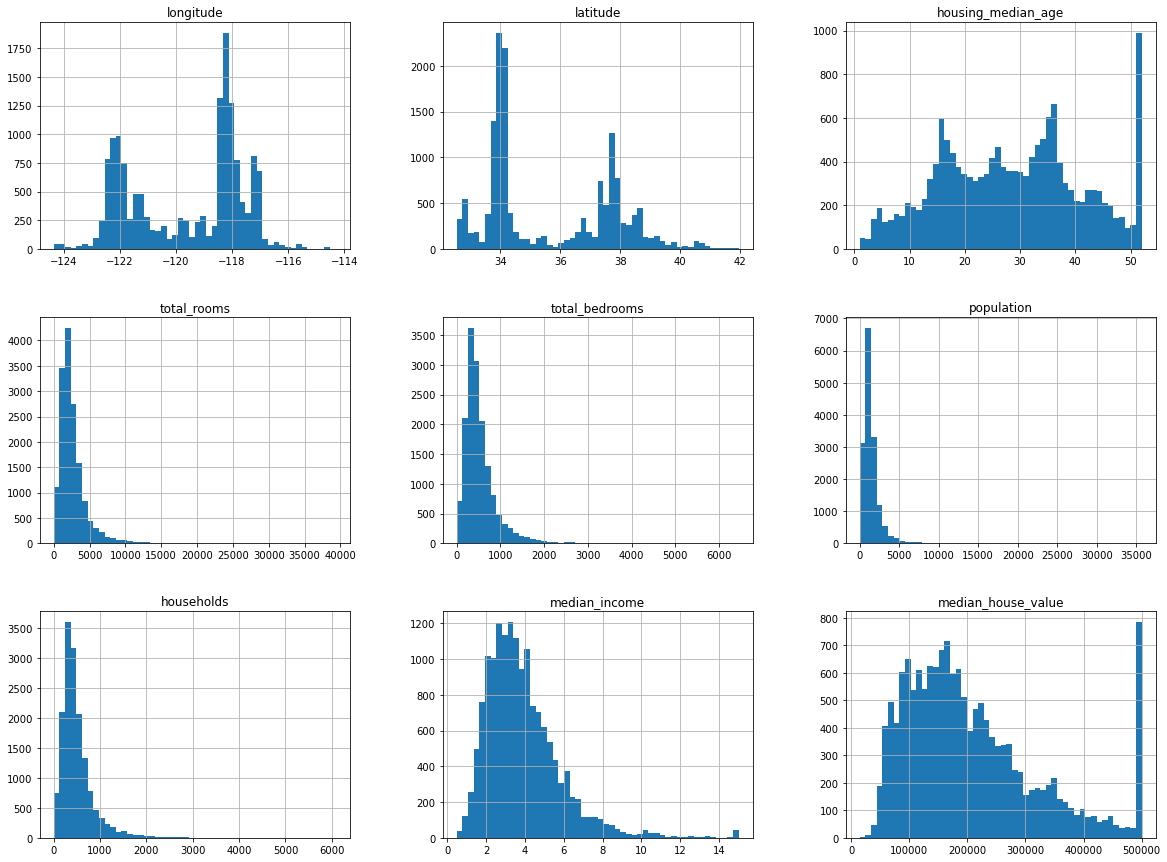

In [6]:
import matplotlib.pyplot as plt

train_set.hist(bins=50, figsize=(20, 15))
plt.show()

You can also look at scatter plots between features, in order to get an impression for how features correlate.

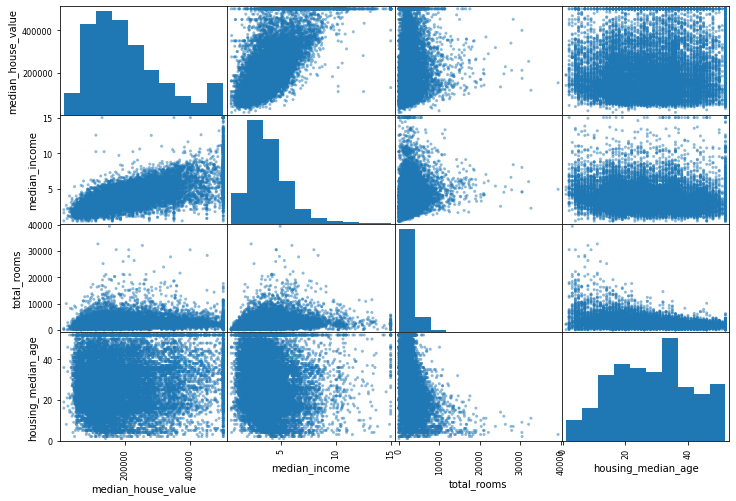

In [7]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(train_set[attributes], figsize=(12,8));

### Assignment 3.2

In real estate, the prase _"location, location, location"_ is often used as a subtle hint at the prime driver for property value. Therefore, it can be informative to plot our quantity of interest (`median_house_value`) against the geographical property locations, as determined by the `longitute` and `latitute` attributes.

In `housing_data_visualizers.py`, write a `plot_housing_data_set` function that visualizes the geographical locations of the `train_set`, and colour-code each data-point according to the `median_house_value`.

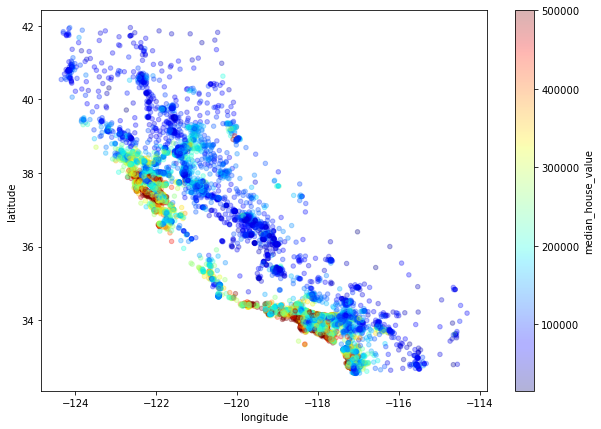

In [8]:
from housing_data_visualizers import plot_housing_data_set

plot_housing_data_set(train_set)

## Pre-processing Pipelines

Now that you have a feel for the data, we can start pre-processing it for analysis. A `scikit-learn` preprocessing `Pipeline` automates this procedure. A `Pipeline` applies sequential operations to a data set, and can for example be used to impute missing values, add additional features, scale feature values, and encode categorical features to a one-hot representation.

Some transformations need to be trained, such as imputing values and scaling. These transformations can be trained on the `train_set`, and stored in the `Pipeline`. The trained `Pipeline` can then later be applied to the `test_set`. This pre-processing procedure ensures that transformations are consistently applied, remain decoupled from your algorithm implementation, and can be versioned.

Each step in a `Pipeline` is defined as a Python class with an `__init__`, `fit` and `transform` method. The pipeline then applies the `transform` and `fit` methods of each consecutive pre-processing step.

Unfortunately, while fitting and transforming, `scikit-learn` requires that the data are represented in a numpy array instead of a pandas `DataFrame`. This makes us lose the column header information, and therefore we must be careful when extending columns.

### Assignment 3.3

In this assignment we define a custom pre-processing step, namely a `HousingAttributesExtender` step, as pre-defined in `housing_attributes_extender.py`. Write a custom `transform` method for the `HousingAttributesExtender` that extends the dataset with a `bedrooms_per_room` feature, dividing the number of `total_bedrooms` by the number of `total_rooms`, and appending the result as the last column.

### Assignment 3.4

Usually, numeric and categorical features require separate pre-processing procedures. Therefore, we define separate pipelines for the numeric and categorical features. In `housing_data_pre_processor.py`, write a `pre_process_housing_data` function that does the following:

For numeric features:
1. Impute missing values by a `SimpleImputer`, using the median of the available feature values
2. Apply the custom `HousingAttributesExtender` to add a `bedrooms_per_room` feature column
3. Normalize the data by a `StandardScaler`.

For categorical features:
1. Impute missing values by `SimpleImputer` that substitutes `"missing"` for any missing values
2. Apply one-hot encoding by a `OneHotEncoder`

In [9]:
pipeline, X_train, y_train, X_test, y_test = pre_process_housing_data(train_set, test_set)

The pipeline can be stored to a file, so that you can use it to transform incoming data once the system is in production.

## Cross-Validation

With our data prepared and preprocessed, we can start training models. The workflow for discovering useful models is as follows. First, a model is trained on a subset of the training set. Then, performance is evaluated on the set that was excluded from the training set. This procedure is called cross-validation, and the set that is excluded from training is called the validation-set.

Thus, at this point we have three data-sets. Earlier we split the full data set into a training- and a test-set. Now, we split off a validation-set from the training-set. Splitting off the validation-set from the training-set is important, because this allows us to freely search for models without becoming biased against unseen data (from the test-set). This way the test-set remains untouched, and only once we have discovered a satisfactory model we will evaluate its performance against the test-set.

### Assignment 3.5
Train a linear regression model on the pre-processed features `X_train` that predicts the median house values `y_train`. Evaluate the predictive performance of you model on the training set `X_train`. In `housing_models.py`, implement the training of your model in the `train_linear_regression_model` function.

In [10]:
from housing_models import *

# Train a simple linear regression model on the training set, using cross-validation
linear_model, rmse_train, rmse_cv = train_linear_regression_model(X_train, y_train)

print("Training error (RMSE):", np.round(rmse_train))
print("Cross-validation error (RMSE):", np.round(rmse_cv))

Training error (RMSE): 68545.0
Cross-validation error (RMSE): 65756.0


### Assignment 3.6
Train a decision tree model on the pre-processed features `X_train` that predicts the median house values `y_train`. Evaluate the predictive performance on the training set `X_train`. In `housing_models.py`, implement the training of your model in the `train_decision_tree_model` function. What do you notice when comparing the training and cross-validation errors, and what does this indicate? (Please answer this question in the source file).

In [11]:
# Train a decision tree model on the training set, using cross-validation
tree_model, rmse_train, rmse_cv = train_decision_tree_model(X_train, y_train)

print("Training error (RMSE):", np.round(rmse_train))
print("Cross-validation error (RMSE):", np.round(rmse_cv))

Training error (RMSE): 0.0
Cross-validation error (RMSE): 68202.0


## k-Fold Cross-Validation

In the previous assignments we applied cross-validation to a single subset of the training set. Unfortunately, this means that the data for cross-validation are excluded from training, which is a waste of good data.

Cross-validation can be performed multiple times, on separate hold-out sets from the training-set. For example, we can split the training-set in three blocks `{a, b, c}`, and train our model on `{b, c}`. Then we evaluate the trained model on `a`, and report a score. Then we train the model on `{a, c}`, and report the cross-validation error evaluated on `b`, etc. This procedure is known as k-fold cross-validation, where k is the number of blocks. On the decision tree model defined earlier, k-fold cross-validation can be implemented as follows.

In [12]:
from sklearn.model_selection import cross_val_score

# Evaluate the cross-validation scores for tree_model, using 5-fold cross-validation
scores = cross_val_score(tree_model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_cv = np.sqrt(-scores)
print("5-fold cross-validation errors:", np.round(rmse_cv))

5-fold cross-validation errors: [74079. 70553. 73863. 70958. 70651.]


Note that five values are returned, one for each cross-validation fold.


## Fine-Tuning Models

We can use k-fold cross-validation in combination with a grid search over parameters to fine-tune our models. Given the `tree_model` from earlier, we wish to improve performance by tuning some hyperparameters. For a decision tree, we can for example tune the maximum depth and maximum number of features.

In order to automate the tuning of hyperparameters, we can construct a `GridSearchCV` instance that can be used to train our model on all possible combinations of hyperparameters, as defined by a `param_grid` dictionary. The `grid_search.fit()` function then trains and evaluates our model on all defined hyperparameter combinations. We can then select the model with the the best k-fold cross-validation score.

In [13]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameter combinations
param_grid = {"max_depth": [3, 10, 30],
              "max_features": [2, 4, 6, 8]}

# Define a GridSearchCV intance that can be used to train tree_model on the combinations defined by param_grid
grid_search = GridSearchCV(tree_model, 
                           param_grid, 
                           scoring="neg_mean_squared_error", 
                           cv=5)

grid_search.fit(X_train, y_train)
current_best_model = grid_search.best_estimator_  # Assign the current best model

print(current_best_model)  # Inspect the constructor for the current best model

DecisionTreeRegressor(max_depth=10, max_features=8)


Note that, because cross-validation is a stochastic procedure (the cross-validation folds are chosen at random), the returned hyperparameters may still vary from run to run. Evaluating model performance on the training set, we now obtain a more believable value for the decision tree model:

In [14]:
# Evaluate model performance on the training set
y_train_predicted = current_best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predicted))
print("Training error (RMSE):", np.round(train_rmse))

Training error (RMSE): 50141.0


## Evaluating Performance on the Test Set

The ultimate test of strength is when we evaluate performance of the current best model against the unseen test set.

In [15]:
y_test_predicted = current_best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predicted))
print("Test error (RMSE):", np.round(test_rmse))

Test error (RMSE): 65194.0


This provides us with a reference value that we can report to our client, and which we can use to compare other candidate models against.


### Assignment 3.7

Experiment with other models that are available in `sklearn`. Follow the following procedure:

- Train your selected model on the pre-processed features `X_train` to that predicts the median house values `y_train`;
- Evaluate the model performance using k-fold cross validation on the training set;
- When you have found a decent model, use grid search to fine-tune the hyperparameters;
- Evaluate the fine-tuned model on the test set.

Try to further decrease the test error and implement your best model in the `train_best_model` function in the `housing_models.py` file. Report the test RMSE and motivate your discovery process and choice of model.

In [16]:
best_model = train_best_model(X_train, y_train)
y_test_predicted = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predicted))
print("Test error (RMSE):", np.round(test_rmse))

Test error (RMSE): 49199.0


### Assignment 3.8
In `housing_predictors.py`, write a `predict_median_house_value` function that accepts a new data-point (as a `DataFrame` object), and applies the stored pipeline and stored fine-tuned model to predict the median house value for that data-point.

In [17]:
from housing_predictors import *

input_datum = query_input_data()

prediction = predict_median_house_value(input_datum)
print("\nPredicted median house value:", np.round(prediction[0]))


Predicted median house value: 183360.0


This functionality then connects the trained model with the user interface, so that the client can start to experiment with actual data. While the client evaluates your model, you could for example start working on a graphical user interface. But we'll leave it here for now.